<a href="https://colab.research.google.com/github/MarihamR/Guided-Projects/blob/main/ImageSegmentation_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=bccd53ecc9795dd96f0177382931fa9d26f80fbce3566380c1ca5c6696a7c0fb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=199534d14e9b146bcbbb623bba3a84ce6922afdfe3cd88fa5c9a4e10bc2a0933
  Stored in directory: /root/.cache/pip/w

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 39.68 MiB/s, done.
Resolving deltas: 100% (3/3), done.


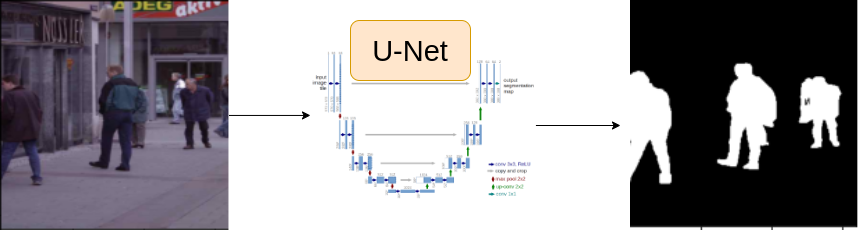

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2
from PIL import Image

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
csv_file="/content/Human-Segmentation-Dataset-master/train.csv"
data_dir="/content "

device="cuda"
epochs=25
lr=0.003
img_size=320
batch=16

Encoder='timm-efficientnet-b0'
weights='imagenet'

## Read and explore dataset

In [ ]:

df=pd.read_csv(csv_file)
print(len(df))
df.head(5)

290


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.loc[4]
img_path=row.images
masks_path=row.masks

image=(Image.open(img_path)).convert("RGB")
mask=(Image.open(masks_path)).convert("RGB")

### Using CV
"""image=cv2.imread(img_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(masks_path)
mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)"""


'image=cv2.imread(img_path)\nimage=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)\n\nmask=cv2.imread(masks_path)\nmask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)'

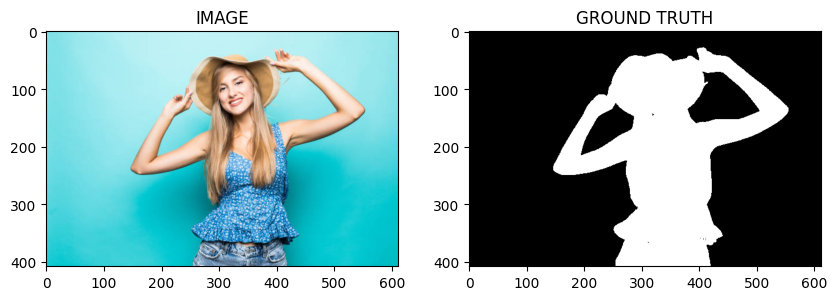

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,test_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def train_aug():
  return A.Compose([
      A.Resize(img_size,img_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def test_aug():
  return A.Compose([
      A.Resize(img_size,img_size)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset 
Dataset is a csv file read by pandas library as a **DataFrame** then converted to **torch tensor**

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations) :
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return (len(self.df))
  
  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    img_path=row.images
    masks_path=row.masks

    image=cv2.imread(img_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(masks_path,cv2.IMREAD_GRAYSCALE) #(h,w)
    ## Add Channel dimension to mask (h,w,c=1)
    mask=np.expand_dims(mask,axis=-1) #torch.unsqueeze

    if self.augmentations:
      data=self.augmentations(image=image, mask=mask)
      image=data["image"]
      mask=data["mask"]

    ##change dimensions from (h,w,c) to (c,w,h) ---> (torch.permute) 
    #torch.transforms.totensor() : converts to tensor + change dimensions
    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0 #normalize values betn o and 1
    mask=torch.round(torch.Tensor(mask)/255.0) # round the values to only o or 1

    return image,mask



In [ ]:
trainset=SegmentationDataset(train_df,train_aug())
testset=SegmentationDataset(test_df,test_aug())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(testset)}")

Size of Trainset : 232
Size of Validset : 58


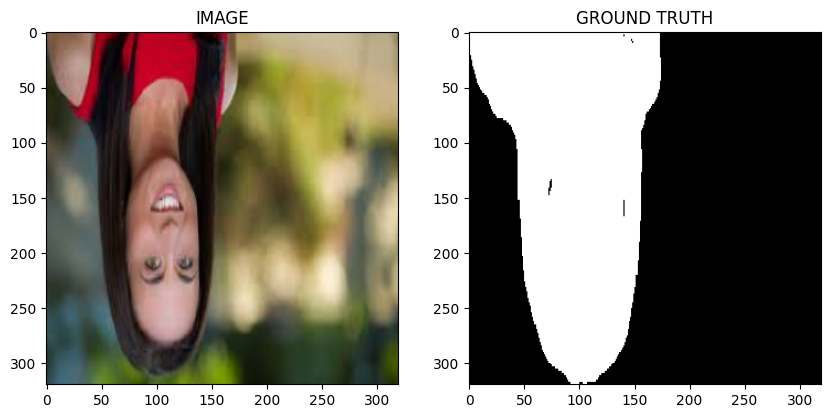

In [ ]:
idx=31
img,msk= trainset[22]
helper.show_image(img,msk)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset,batch_size=batch,shuffle=True)
testloader=DataLoader(testset,batch_size=batch,shuffle=False)

In [ ]:
print ("trainloader length:", len(trainloader))
print ("testloader length:", len(testloader))


trainloader length: 15
testloader length: 4


Getting the length of 1 batch ( 1 batch contain 16 sample)

In [ ]:
for image, mask in trainloader:
  break #break after first iteration

print ("one batch have image shape:",image.shape)
print ("one batch have  mask shape:", mask.shape)

one batch have image shape: torch.Size([16, 3, 320, 320])
one batch have  mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.arc=smp.Unet(
    encoder_name=Encoder,        # choose encoder: efficientnet-b0
    encoder_weights=weights,   
    in_channels=3,                 #RGB channels
    classes=1,                     # Binary Segmentation Problem
    activation=None                # no sigmoid or softmax therefor logits only not their probabilites
)
  def forward(self,images,masks=None):
    logits=self.arc(images)

    if masks !=None: # if not testing (if training calculate loss)
      loss1=DiceLoss(mode="binary")(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      loss=loss1+loss2
      return logits,loss
    
    return logits

In [ ]:
model=SegmentationModel().to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 246MB/s]


In [ ]:
model;

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(dataloader,model,optimizer):
  model.train()
  total_loss=0.0

  for img,mask in tqdm(dataloader):
    img=img.to(device)
    mask=mask.to(device)

    optimizer.zero_grad()
    logits,loss=model(img,mask)
    loss.backward()
    optimizer.step()
    
    total_loss+=loss.item()
  return (total_loss/len(dataloader))

In [ ]:
def eval_fn(dataloader,model):
  model.eval()
  total_loss=0.0

  with torch.no_grad():
    for img,mask in tqdm(dataloader):
      img=img.to(device)
      mask=mask.to(device)

      logits,loss=model(img,mask)
      
      total_loss+=loss.item()
    return (total_loss/len(dataloader))

# Task 8 : Train Model

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

In [ ]:
best_valid_loss=np.Inf

for i in range(epochs):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(testloader,model)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),"best_model.pt")
    print("saved_model")
    best_valid_loss=valid_loss

  print (f"Epoch:{i+1} train_loss={train_loss},valid_loss={valid_loss}")



100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


saved_model
Epoch:1 train_loss=0.36150451600551603,valid_loss=0.4762410670518875


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


saved_model
Epoch:2 train_loss=0.28801998297373455,valid_loss=0.3004126772284508


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


saved_model
Epoch:3 train_loss=0.2700863927602768,valid_loss=0.29480236023664474


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch:4 train_loss=0.2936759263277054,valid_loss=0.30761539563536644


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


saved_model
Epoch:5 train_loss=0.23891150554021198,valid_loss=0.27680498361587524


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


saved_model
Epoch:6 train_loss=0.19240464866161347,valid_loss=0.208747249096632


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch:7 train_loss=0.15335644831260045,valid_loss=0.22354233264923096


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch:8 train_loss=0.18615269809961318,valid_loss=0.23885755240917206


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch:9 train_loss=0.19842752863963445,valid_loss=0.24041062593460083


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch:10 train_loss=0.16118549108505248,valid_loss=0.24045123532414436


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch:11 train_loss=0.13635640392700832,valid_loss=0.2244054675102234


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


saved_model
Epoch:12 train_loss=0.15315115998188655,valid_loss=0.2044881321489811


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


saved_model
Epoch:13 train_loss=0.15320460548003514,valid_loss=0.19609832763671875


100%|██████████| 4/4 [00:00<00:00,  4.17it/s]


Epoch:14 train_loss=0.14577360600233077,valid_loss=0.2616322413086891


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch:15 train_loss=0.21562282840410868,valid_loss=0.2656106576323509


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch:16 train_loss=0.1865033894777298,valid_loss=0.31068703159689903


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch:17 train_loss=0.1458316703637441,valid_loss=0.20460931956768036


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch:18 train_loss=0.14734280109405518,valid_loss=0.25145401433110237


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


Epoch:19 train_loss=0.2356444219748179,valid_loss=0.23373103514313698


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch:20 train_loss=0.1589818651477496,valid_loss=0.2625872567296028


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch:21 train_loss=0.12791340053081512,valid_loss=0.21426938101649284


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch:22 train_loss=0.1050537422299385,valid_loss=0.21732433140277863


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


saved_model
Epoch:23 train_loss=0.09507183829943339,valid_loss=0.19493527337908745


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]


Epoch:24 train_loss=0.09343158006668091,valid_loss=0.19731276854872704


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

Epoch:25 train_loss=0.08303645104169846,valid_loss=0.21042578481137753


# Task 9 : Inference

In [ ]:
idx=20
model.load_state_dict(torch.load("/content/best_model.pt"))

img,mask=testset[idx]

logit_mask=model(img.to(device).unsqueeze(0)) #dim (1,C,W,H)

#Add sigmoid activation function to output mask betn 0 and 1
pred_mask=torch.sigmoid(logit_mask)

#round pred mask to o or 1 
# 1 if pred>thresh(0.5), o otherwise
pred_mask=(pred_mask>0.5)*1



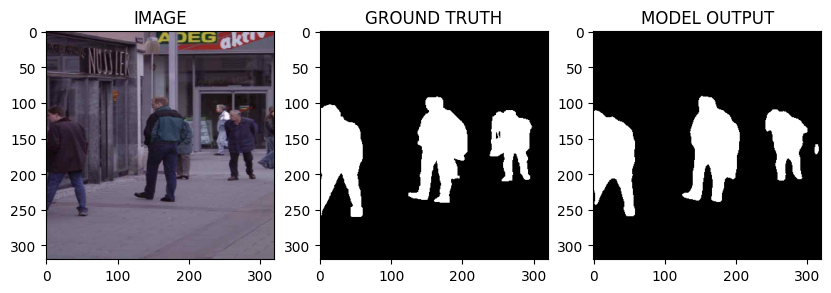

In [ ]:
helper.show_image(img,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya